In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

In [2]:
N = 10000

In [3]:
projection_df = (
    pl.read_csv("data/projected-phenotypes/projection_matrix.tsv", separator="\t")
    .to_pandas()
    .set_index("index")
)
projection_df.head(2)

,projection_001,projection_002,projection_003,projection_004,projection_005,projection_006,projection_007,projection_008,projection_009,projection_010
index,,,,,,,,,,
feature_01,0.494257,0.149846,0.416713,0.465716,0.499354,-0.403010,0.566804,-0.059001,-0.035533,0.165651
feature_02,0.040359,0.544579,0.324024,0.025287,0.118682,0.137601,0.891338,-0.079973,0.107773,-0.344575


In [4]:
def indirect_gwas(beta_df, se_df, cov_df, projection_df, N, n_covar, method_normalizes_pheno=False, method_normalizes_geno=False):
    # Phenotypic variance of each feature (features x 1)
    var_x = np.diag(cov_df)
    var_x_s = pd.Series(var_x, index=cov_df.columns)
    if method_normalizes_pheno:
        var_x_s = var_x_s.map(lambda x: 1.0)
    
    # Phenotypic variance of the projected phenotypes (projections x 1)
    var_y = np.diag(projection_df.T @ cov_df @ projection_df)
    var_y_s = pd.Series(var_y, index=projection_df.columns)
    
    if method_normalizes_pheno:
        var_y_s = var_y_s.map(lambda x: 1.0)
    
    indirect_beta_df = beta_df @ projection_df
    
    # Estimate the variance of the genotype using GWAS standard errors
    var_g_i_df = var_x_s / (se_df.pow(2) * (N - n_covar - 1) + beta_df.pow(2))
    print(var_g_i_df)
    var_g_s = var_g_i_df.mean(axis=1)
    if method_normalizes_geno:
        var_g_s = var_g_s.map(lambda x: 1.0)
    
    # Create a SNP by projection matrix with value i,j = Var(y_j) / Var(g_i)
    variance_ratio = (
        pd.DataFrame(1, index=se_df.index, columns=projection_df.columns)
        .mul(var_y_s, axis=1)
        .div(var_g_s, axis=0)
    )
    
    assert variance_ratio.iloc[1, 2] == var_y_s.iloc[2] / var_g_s.iloc[1]
    
    indirect_se_df = np.sqrt(
        (1 / (N - n_covar - 1)) * (variance_ratio - indirect_beta_df.pow(2))
    )
    
    indirect_gwas_df = (
        pd.concat([
            indirect_beta_df
                .melt(ignore_index=False, var_name="projection", value_name="beta")
                .reset_index()
                .set_index(["projection", "snp_id"]),
            indirect_se_df
                .melt(ignore_index=False, var_name="projection", value_name="se")
                .reset_index()
                .set_index(["projection", "snp_id"]),
        ], axis=1)
        .reset_index()
        .pipe(pl.DataFrame)
    )
    return indirect_gwas_df

    
def format_feature_gwas(raw_df):
    # SNPs by features
    feature_beta_df = (
        raw_df
        .pivot(index="snp_id", on="feature", values="beta")
        .to_pandas()
        .set_index("snp_id")
    )
    
    # SNPs by features
    feature_se_df = (
        raw_df
        .pivot(index="snp_id", on="feature", values="se")
        .to_pandas()
        .set_index("snp_id")
    )
    return feature_beta_df, feature_se_df


import rpy2.robjects as robjects


def load_saige_residuals(path):
    robjects.r['load'](path)
    return np.asarray(robjects.r["modglmm"].rx2("residuals"))

# OLS univariate

In [5]:
feature_gwas_df = (
    pl.scan_csv("data/gwas/ols_univariate/features/*.glm.linear", separator="\t", glob=True, include_file_paths="feature")
    .select(
        (
            pl.lit("feature_") + pl.col("feature")
            .str.strip_prefix("data/gwas/ols_univariate/features/result.PHENO")
            .str.strip_suffix(".glm.linear")
            .str.zfill(2)
        ).alias("feature"),
        pl.col("ID").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower())
    )
    .collect()
)
feature_gwas_df.head(2)

feature,snp_id,beta,se
str,str,f64,f64
"""feature_01""","""SNP_1""",0.0229625,0.0144725
"""feature_01""","""SNP_2""",-0.018452,0.017653


In [6]:
# Phenotypic covariance matrix of the features (features x features)
cov_df = (
    pl.read_csv("data/simulated-phenotypes/Ysim_saige.txt", separator="\t")
    .select("^feature_.*$")
    .to_pandas()
    .cov()
)

# Format feature summary statistics
feature_beta_df, feature_se_df = format_feature_gwas(feature_gwas_df)

# Run indirect GWAS
indirect_gwas_df = indirect_gwas(feature_beta_df, feature_se_df, cov_df, projection_df, N=N, n_covar=0)

           feature_01  feature_02  feature_03  feature_04  feature_05  \
snp_id                                                                  
SNP_1        0.477361    0.477365    0.477363    0.477363    0.477367   
SNP_2        0.320892    0.320893    0.320894    0.320894    0.320894   
SNP_3        0.181592    0.181591    0.181591    0.181591    0.181591   
SNP_4        0.324099    0.324100    0.324098    0.324099    0.324101   
SNP_5        0.479658    0.479653    0.479658    0.479658    0.479653   
...               ...         ...         ...         ...         ...   
SNP_9996     0.480783    0.480777    0.480779    0.480783    0.480783   
SNP_9997     0.183065    0.183066    0.183065    0.183065    0.183065   
SNP_9998     0.480169    0.480169    0.480166    0.480165    0.480170   
SNP_9999     0.184196    0.184196    0.184196    0.184197    0.184195   
SNP_10000    0.178438    0.178437    0.178437    0.178437    0.178437   

           feature_06  feature_07  feature_08  fea

In [7]:
direct_gwas_df = (
    pl.scan_csv("data/gwas/ols_univariate/projections/*.glm.linear", separator="\t", glob=True, include_file_paths="projection")
    .select(
        pl.col("projection")
            .str.strip_prefix("data/gwas/ols_univariate/projections/result.")
            .str.strip_suffix(".glm.linear"),
        pl.col("ID").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower())
    )
    .collect()
)
direct_gwas_df.head(2)

projection,snp_id,beta,se
str,str,f64,f64
"""projection_001""","""SNP_1""",0.004142,0.0144742
"""projection_001""","""SNP_2""",-0.007848,0.0176537


In [8]:
comparison_df = (
    indirect_gwas_df
    .with_columns(
        pl.col("beta").truediv(pl.col("se")).pow(2).alias("chisq")
    )
    .unpivot(index=["projection", "snp_id"], on=["beta", "se", "chisq"], variable_name="sumstat")
    .join(
        direct_gwas_df
            .with_columns(
                pl.col("beta").truediv(pl.col("se")).pow(2).alias("chisq")
            )
            .unpivot(index=["projection", "snp_id"], on=["beta", "se", "chisq"], variable_name="sumstat"), 
        on=["projection", "snp_id", "sumstat"], suffix="_direct"
    )
    .rename({"value": "indirect", "value_direct": "direct"})
)
comparison_df.write_csv("data/gwas/ols_univariate/comparison.tsv", separator="\t")
comparison_df.head(2)

projection,snp_id,sumstat,indirect,direct
str,str,str,f64,f64
"""projection_001""","""SNP_1""","""beta""",0.004142,0.004142
"""projection_001""","""SNP_2""","""beta""",-0.007848,-0.007848


In [9]:
(
    comparison_df
    .group_by("sumstat")
    .agg(
        rss=(pl.col("indirect") - pl.col("direct")).pow(2).sum(),
        tss=(pl.col("direct") - pl.col("direct").mean()).pow(2).sum(),
    )
    .select(pl.col("sumstat"), r2=1 - pl.col("rss") / pl.col("tss"))
)

sumstat,r2
str,f64
"""chisq""",1.0
"""beta""",1.0
"""se""",1.0


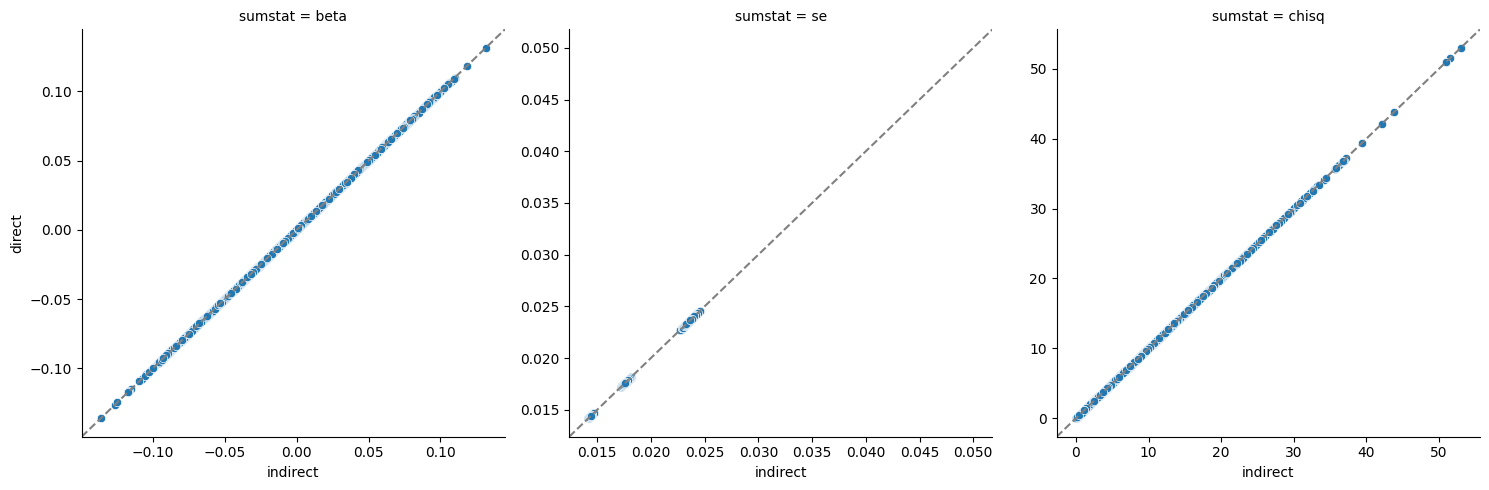

In [10]:
(
    comparison_df
    .pipe(sns.relplot, x="indirect", y="direct", col="sumstat", kind="scatter", facet_kws={"sharex": False, "sharey": False})
    .map(lambda *args, **kwargs: plt.axline((0.05, 0.05), slope=1, color="gray", linestyle="dashed"))
)

# OLS multivariate

In [11]:
feature_gwas_df = (
    pl.scan_csv("data/gwas/ols_multivariate/features/*.glm.linear", separator="\t", glob=True, include_file_paths="feature")
    .select(
        (
            pl.lit("feature_") + pl.col("feature")
            .str.strip_prefix("data/gwas/ols_multivariate/features/result.PHENO")
            .str.strip_suffix(".glm.linear")
            .str.zfill(2)
        ).alias("feature"),
        pl.col("ID").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower())
    )
    .collect()
)
feature_gwas_df.head(2)

feature,snp_id,beta,se
str,str,f64,f64
"""feature_01""","""SNP_1""",0.0240082,0.010959
"""feature_01""","""SNP_2""",-0.0238,0.0133628


In [12]:
# Phenotypic covariance matrix of the features (features x features)
full_pheno_df = pl.read_csv("data/simulated-phenotypes/Ysim_saige.txt", separator="\t")

X_covar_df = full_pheno_df.select("^.*Confounder.*$", pl.lit(1).alias("const")).to_pandas()
Y_feature_df = full_pheno_df.select("^feature_.*$").to_pandas()

beta, _, _, _ = np.linalg.lstsq(X_covar_df, Y_feature_df)
beta_df = pd.DataFrame(beta, index=X_covar_df.columns, columns=Y_feature_df.columns)
residualized_pheno_df = Y_feature_df - X_covar_df @ beta_df

cov_df = residualized_pheno_df.cov(ddof=6)

# Format feature summary statistics
feature_beta_df, feature_se_df = format_feature_gwas(feature_gwas_df)

# Run indirect GWAS
indirect_gwas_df = indirect_gwas(feature_beta_df, feature_se_df, cov_df, projection_df, N=N, n_covar=5)

           feature_01  feature_02  feature_03  feature_04  feature_05  \
snp_id                                                                  
SNP_1        0.477219    0.477222    0.477219    0.477220    0.477221   
SNP_2        0.321022    0.321023    0.321022    0.321021    0.321022   
SNP_3        0.181560    0.181559    0.181560    0.181560    0.181559   
SNP_4        0.324159    0.324156    0.324158    0.324155    0.324155   
SNP_5        0.479671    0.479674    0.479676    0.479678    0.479675   
...               ...         ...         ...         ...         ...   
SNP_9996     0.480930    0.480928    0.480928    0.480924    0.480927   
SNP_9997     0.183121    0.183120    0.183121    0.183121    0.183121   
SNP_9998     0.480311    0.480310    0.480310    0.480308    0.480308   
SNP_9999     0.184177    0.184177    0.184177    0.184177    0.184176   
SNP_10000    0.178395    0.178394    0.178394    0.178394    0.178395   

           feature_06  feature_07  feature_08  fea

In [13]:
direct_gwas_df = (
    pl.scan_csv("data/gwas/ols_multivariate/projections/*.glm.linear", separator="\t", glob=True, include_file_paths="projection")
    .select(
        pl.col("projection")
            .str.strip_prefix("data/gwas/ols_multivariate/projections/result.")
            .str.strip_suffix(".glm.linear"),
        pl.col("ID").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower())
    )
    .collect()
)
direct_gwas_df.head(2)

projection,snp_id,beta,se
str,str,f64,f64
"""projection_001""","""SNP_1""",0.009358,0.0142941
"""projection_001""","""SNP_2""",-0.009908,0.0174281


In [14]:
comparison_df = (
    indirect_gwas_df
    .with_columns(
        pl.col("beta").truediv(pl.col("se")).pow(2).alias("chisq")
    )
    .unpivot(index=["projection", "snp_id"], on=["beta", "se", "chisq"], variable_name="sumstat")
    .join(
        direct_gwas_df
            .with_columns(
                pl.col("beta").truediv(pl.col("se")).pow(2).alias("chisq")
            )
            .unpivot(index=["projection", "snp_id"], on=["beta", "se", "chisq"], variable_name="sumstat"), 
        on=["projection", "snp_id", "sumstat"], suffix="_direct"
    )
    .rename({"value": "indirect", "value_direct": "direct"})
)
comparison_df.write_csv("data/gwas/ols_multivariate/comparison.tsv", separator="\t")
comparison_df.head(2)

projection,snp_id,sumstat,indirect,direct
str,str,str,f64,f64
"""projection_001""","""SNP_1""","""beta""",0.009358,0.009358
"""projection_001""","""SNP_2""","""beta""",-0.009908,-0.009908


In [15]:
(
    comparison_df
    .group_by("sumstat")
    .agg(
        rss=(pl.col("indirect") - pl.col("direct")).pow(2).sum(),
        tss=(pl.col("direct") - pl.col("direct").mean()).pow(2).sum(),
    )
    .select(pl.col("sumstat"), r2=1 - pl.col("rss") / pl.col("tss"))
)

sumstat,r2
str,f64
"""chisq""",1.0
"""beta""",1.0
"""se""",1.0


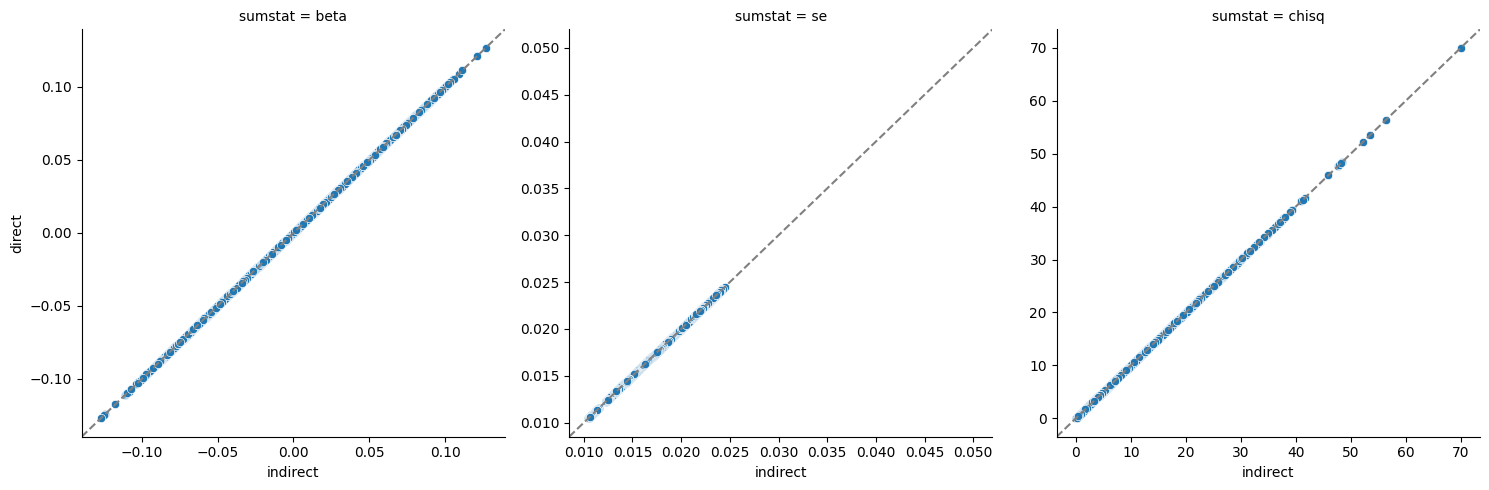

In [16]:
(
    comparison_df
    .pipe(sns.relplot, x="indirect", y="direct", col="sumstat", kind="scatter", facet_kws={"sharex": False, "sharey": False})
    .map(lambda *args, **kwargs: plt.axline((0.05, 0.05), slope=1, color="gray", linestyle="dashed"))
)

# Regenie

In [17]:
direct_gwas_df = (
    pl.scan_csv("data/gwas/regenie/projections/result_projection_*.regenie", separator=" ", glob=True, include_file_paths="projection")
    .select(
        pl.col("projection")
            .str.strip_prefix("data/gwas/regenie/projections/result_")
            .str.strip_suffix(".regenie"),
        pl.col("ID").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower())
    )
    .collect()
)
direct_gwas_df.head(2)

projection,snp_id,beta,se
str,str,f64,f64
"""projection_001""","""SNP_1""",-0.009358,0.0142936
"""projection_001""","""SNP_2""",0.009908,0.0174275


In [18]:
feature_gwas_df = (
    pl.scan_csv("data/gwas/regenie/features/result_feature_*.regenie", separator=" ", glob=True, include_file_paths="feature")
    .select(
        pl.col("feature")
            .str.strip_prefix("data/gwas/regenie/features/result_")
            .str.strip_suffix(".regenie"),
        pl.col("ID").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower()),
    )
    .collect()
)
feature_beta_df, feature_se_df = format_feature_gwas(feature_gwas_df)
feature_gwas_df.head(2)

feature,snp_id,beta,se
str,str,f64,f64
"""feature_01""","""SNP_1""",-0.024008,0.0109611
"""feature_01""","""SNP_2""",0.0237998,0.0133643


In [19]:
features_df = pl.read_csv("data/simulated-phenotypes/Ysim_plink_names.txt", separator="\t")
projected_df = pl.read_csv("data/projected-phenotypes/phenotypes_saige.tsv", separator="\t")

Y_proj = projected_df.select("IID", "^projection_.*$").to_pandas().set_index("IID")
X_features = features_df.select("IID", "^feature_.*$").to_pandas().set_index("IID")

X_covar = projected_df.select("^.*Confounder.*$", const=1.0).to_pandas().values
P = np.eye(X_covar.shape[0]) - X_covar @ np.linalg.inv(X_covar.T @ X_covar) @ X_covar.T
P = pd.DataFrame(P, index=X_features.index, columns=X_features.index)

N = 10000
C = 6

cov_df = (P @ X_features).cov()

In [20]:
# Verify that we correctly estimate yty for the features
yty_direct = (P @ X_features).pow(2).sum()
yty_indirect = np.diag(cov_df) * (N - 1)
assert np.allclose(yty_direct, yty_indirect)

# Verify that we correctly estimate yty for the projections
yty_direct = (P @ X_features @ projection_df).pow(2).sum()
yty_indirect = np.diag(projection_df.T @ cov_df @ projection_df) * (N - 1)
assert np.allclose(yty_direct, yty_indirect)

In [21]:
# 1. Compute yty for the features
yty_features = (N - 1) * np.diag(cov_df)

# 2. Back out gtg
gtg_i = yty_features / ((N - C) * feature_se_df.pow(2))
gtg = gtg_i.mean(axis=1)

# 3. Estimate indirect beta
indirect_beta = feature_beta_df @ projection_df

# 4. Back out yty
yty = np.diag(projection_df.T @ cov_df @ projection_df) * (N - 1)

# 5. Create a wide dataframe with yty / gtg
variance_ratio = (
    pd.DataFrame(1, index=feature_se_df.index, columns=projection_df.columns)
    .mul(yty, axis=1)
    .div(gtg, axis=0)
)

# 6. Estimate indirect standard error
indirect_se = np.sqrt(variance_ratio / (N - C))

In [22]:
indirect_gwas_df = (
    pd.concat([
        indirect_beta
            .melt(ignore_index=False, var_name="projection", value_name="beta")
            .reset_index()
            .set_index(["projection", "snp_id"]),
        indirect_se
            .melt(ignore_index=False, var_name="projection", value_name="se")
            .reset_index()
            .set_index(["projection", "snp_id"]),
    ], axis=1)
    .reset_index()
    .pipe(pl.DataFrame)
)

comparison_df = (
    indirect_gwas_df
    .with_columns(
        pl.col("beta").truediv(pl.col("se")).pow(2).alias("chisq")
    )
    .unpivot(index=["projection", "snp_id"], on=["beta", "se", "chisq"], variable_name="sumstat")
    .join(
        direct_gwas_df
            .with_columns(
                pl.col("beta").truediv(pl.col("se")).pow(2).alias("chisq")
            )
            .unpivot(index=["projection", "snp_id"], on=["beta", "se", "chisq"], variable_name="sumstat"), 
        on=["projection", "snp_id", "sumstat"], suffix="_direct"
    )
    .rename({"value": "indirect", "value_direct": "direct"})
)
comparison_df.write_csv("data/gwas/regenie/comparison.tsv", separator="\t")
comparison_df.head(2)

projection,snp_id,sumstat,indirect,direct
str,str,str,f64,f64
"""projection_001""","""SNP_1""","""beta""",-0.009358,-0.009358
"""projection_001""","""SNP_2""","""beta""",0.009908,0.009908


In [23]:
(
    comparison_df
    .group_by("sumstat")
    .agg(
        rss=(pl.col("indirect") - pl.col("direct")).pow(2).sum(),
        tss=(pl.col("direct") - pl.col("direct").mean()).pow(2).sum(),
    )
    .select(pl.col("sumstat"), r2=1 - pl.col("rss") / pl.col("tss"))
)

sumstat,r2
str,f64
"""chisq""",1.0
"""beta""",1.0
"""se""",1.0


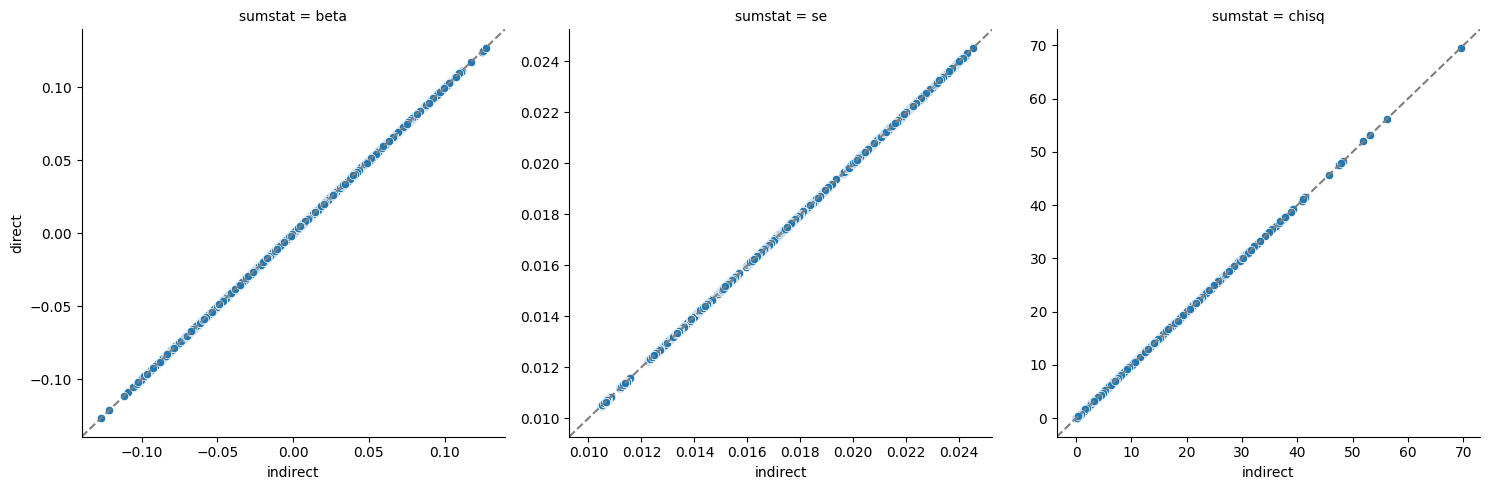

In [24]:
(
    comparison_df
    .pipe(sns.relplot, x="indirect", y="direct", col="sumstat", kind="scatter", facet_kws={"sharex": False, "sharey": False})
    .map(lambda *args, **kwargs: plt.axline((0.01, 0.01), slope=1, color="gray", linestyle="dashed"))
)

# SAIGE

In [25]:
direct_gwas_df = (
    pl.scan_csv("data/gwas/saige/projections/projection_[01][0123456789][0123456789].txt", separator="\t", glob=True, include_file_paths="projection")
    .select(
        pl.col("projection")
            .str.strip_prefix("data/gwas/saige/projections/")
            .str.strip_suffix(".txt"),
        pl.col("MarkerID").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower())
    )
    .collect()
)
direct_gwas_df.head(2)

projection,snp_id,beta,se
str,str,f64,f64
"""projection_001""","""SNP_1""",0.001239,0.0120805
"""projection_001""","""SNP_10""",0.008534,0.0120384


In [26]:
feature_gwas_df = (
    pl.scan_csv("data/gwas/saige/features/feature_[01][0123456789].txt", separator="\t", glob=True, include_file_paths="feature")
    .select(
        pl.col("feature")
            .str.strip_prefix("data/gwas/saige/features/")
            .str.strip_suffix(".txt"),
        pl.col("MarkerID").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower())
    )
    .collect()
)
feature_gwas_df.head(2)

feature,snp_id,beta,se
str,str,f64,f64
"""feature_01""","""SNP_1""",-0.020962,0.0108668
"""feature_01""","""SNP_10""",-0.00609,0.010829


In [27]:
C = 6

pheno_df = pl.read_csv("data/simulated-phenotypes/Ysim_saige.txt", separator="\t")

X_covar = (
    pheno_df
    .select("^.+Confounder.+$", const=1.0)
    .to_numpy()
)
X_features = (
    pheno_df
    .select("^feature_.+$")
    .to_pandas()
)
P = np.eye(N) - X_covar @ np.linalg.inv(X_covar.T @ X_covar) @ X_covar.T
P = pd.DataFrame(P, index=X_features.index, columns=X_features.index)

In [28]:
full_residuals = dict()
for i in range(1, 11):
    feature_name = f"feature_{i:02}"
    residuals_path = f"data/gwas/saige/features/{feature_name}.rda"
    residuals = load_saige_residuals(residuals_path)
    full_residuals[feature_name] = residuals.ravel()

full_residuals_df = pd.DataFrame(full_residuals)

cov_df = full_residuals_df.cov()

# Format feature summary statistics
feature_beta_df, feature_se_df = format_feature_gwas(feature_gwas_df)

# raw_cov_df = X_features.cov()
# normalized_projection_df = projection_df / np.sqrt(np.diag(projection_df.T @ raw_cov_df @ projection_df))
# normalized_projection_df = projection_df / np.sqrt(np.diag(projection_df.T @ cov_df @ projection_df))
normalized_projection_df = projection_df

# Run indirect GWAS
indirect_gwas_df = indirect_gwas(feature_beta_df, feature_se_df, cov_df, normalized_projection_df, N=N, n_covar=6)

           feature_01  feature_02  feature_03  feature_04  feature_05  \
snp_id                                                                  
SNP_1        0.374007    0.146621    0.148512    0.087846    0.110995   
SNP_10       0.376751    0.147673    0.149546    0.088464    0.111777   
SNP_100      0.374976    0.146979    0.148849    0.088046    0.111228   
SNP_1000     0.253172    0.099233    0.100499    0.059453    0.075122   
SNP_10000    0.139860    0.054807    0.055425    0.032834    0.041486   
...               ...         ...         ...         ...         ...   
SNP_9995     0.376904    0.147733    0.149628    0.088508    0.111838   
SNP_9996     0.377045    0.147787    0.149638    0.088501    0.111835   
SNP_9997     0.143569    0.056272    0.056986    0.033710    0.042595   
SNP_9998     0.376563    0.147594    0.149477    0.088418    0.111723   
SNP_9999     0.144386    0.056593    0.057317    0.033904    0.042840   

           feature_06  feature_07  feature_08  fea

In [29]:
comparison_df = (
    indirect_gwas_df
    .with_columns(
        pl.col("beta").truediv(pl.col("se")).pow(2).alias("chisq")
    )
    .unpivot(index=["projection", "snp_id"], on=["beta", "se", "chisq"], variable_name="sumstat")
    .join(
        direct_gwas_df
            .with_columns(
                pl.col("beta").truediv(pl.col("se")).pow(2).alias("chisq")
            )
            .unpivot(index=["projection", "snp_id"], on=["beta", "se", "chisq"], variable_name="sumstat"), 
        on=["projection", "snp_id", "sumstat"], suffix="_direct"
    )
    .rename({"value": "indirect", "value_direct": "direct"})
    .pipe(
        # Calibrate standard errors
        lambda df: (
            df
            .filter(pl.col("snp_id").eq("SNP_1") & pl.col("sumstat").eq("se"))
            .select("projection", "sumstat", factor=pl.col("direct") / pl.col("indirect"))
            .join(df, on=["projection", "sumstat"], how="right")
            .filter(pl.col("sumstat").ne("chisq"))
            .with_columns(pl.col("factor").fill_null(1.0))
            .with_columns(pl.col("indirect").mul(pl.col("factor")))
            .select("projection", "snp_id", "sumstat", "indirect", "direct")
            .unpivot(["indirect", "direct"], index=["projection", "snp_id", "sumstat"])
            .pivot(["sumstat"], values="value")
            .with_columns(chisq=pl.col("beta").truediv(pl.col("se")).pow(2))
            .unpivot(["beta", "se", "chisq"], index=["projection", "snp_id", "variable"], variable_name="sumstat")
            .pivot(["variable"], values="value")
        )
    )
)
comparison_df.write_csv("data/gwas/saige/comparison.tsv", separator="\t")
comparison_df.head(2)

projection,snp_id,sumstat,indirect,direct
str,str,str,f64,f64
"""projection_001""","""SNP_1""","""beta""",-0.001422,0.001239
"""projection_001""","""SNP_10""","""beta""",0.006841,0.008534


In [30]:
(
    comparison_df
    .group_by("sumstat")
    .agg(
        rss=(pl.col("indirect") - pl.col("direct")).pow(2).sum(),
        tss=(pl.col("direct") - pl.col("direct").mean()).pow(2).sum(),
    )
    .select(pl.col("sumstat"), r2=1 - pl.col("rss") / pl.col("tss"))
)

sumstat,r2
str,f64
"""se""",1.0
"""chisq""",0.804121
"""beta""",0.893149


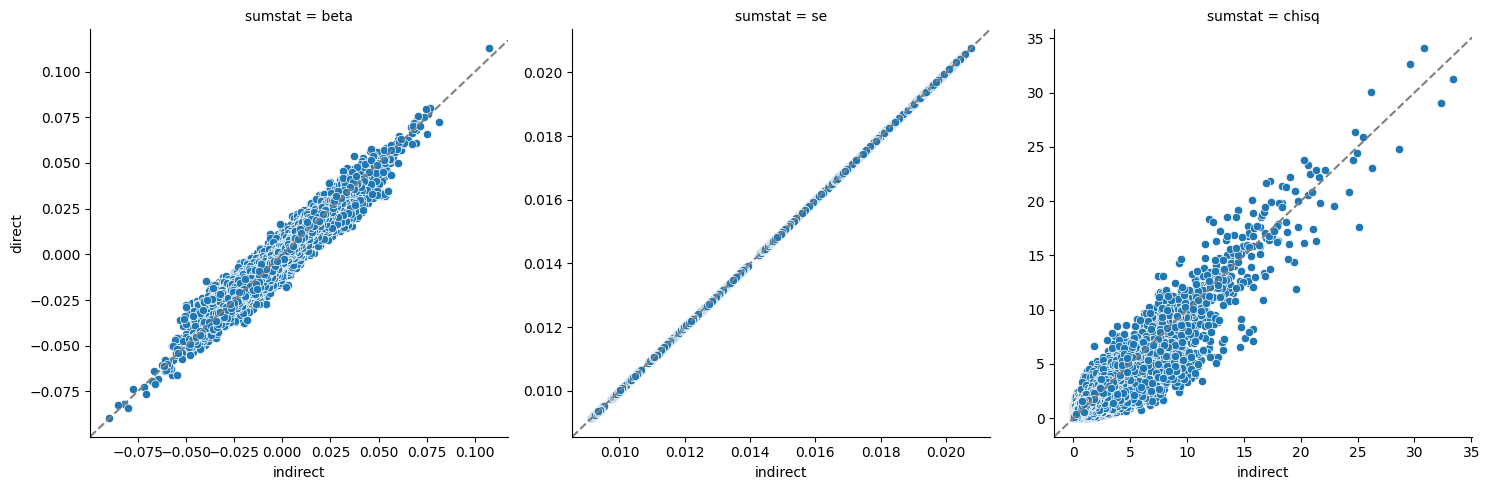

In [31]:
(
    comparison_df
    .pipe(sns.relplot, x="indirect", y="direct", col="sumstat", kind="scatter", facet_kws={"sharex": False, "sharey": False})
    .map(lambda *args, **kwargs: plt.axline((0.01, 0.01), slope=1, color="gray", linestyle="dashed"))
)

# FastGWA

In [32]:
feature_gwas_df = (
    pl.scan_csv("data/gwas/fastgwa/features/*.fastGWA", separator="\t", glob=True, include_file_paths="feature")
    .select(
        (
            pl.lit("feature_") + pl.col("feature")
            .str.strip_prefix("data/gwas/fastgwa/features/result_")
            .str.strip_suffix(".fastGWA")
            .str.zfill(2)
        ).alias("feature"),
        pl.col("SNP").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower())
    )
    .collect()
)
feature_gwas_df.head(2)

feature,snp_id,beta,se
str,str,f64,f64
"""feature_01""","""SNP_1""",-0.023989,0.0109519
"""feature_01""","""SNP_2""",0.0237974,0.0133588


In [33]:
# Phenotypic covariance matrix of the features (features x features)
full_pheno_df = pl.read_csv("data/simulated-phenotypes/Ysim_saige.txt", separator="\t")

X_covar_df = full_pheno_df.select("^.*Confounder.*$", pl.lit(1).alias("const")).to_pandas()
Y_feature_df = full_pheno_df.select("^feature_.*$").to_pandas()

beta, _, _, _ = np.linalg.lstsq(X_covar_df, Y_feature_df)
beta_df = pd.DataFrame(beta, index=X_covar_df.columns, columns=Y_feature_df.columns)
residualized_pheno_df = Y_feature_df - X_covar_df @ beta_df

cov_df = residualized_pheno_df.cov(ddof=6)

# Format feature summary statistics
feature_beta_df, feature_se_df = format_feature_gwas(feature_gwas_df)

# Run indirect GWAS
indirect_gwas_df = indirect_gwas(feature_beta_df, feature_se_df, cov_df, projection_df, N=N, n_covar=6)

           feature_01  feature_02  feature_03  feature_04  feature_05  \
snp_id                                                                  
SNP_1        0.477886    0.477889    0.477845    0.477938    0.477889   
SNP_2        0.321247    0.321246    0.321267    0.321187    0.321247   
SNP_3        0.181791    0.181791    0.181745    0.181747    0.181791   
SNP_4        0.324455    0.324455    0.324427    0.324483    0.324457   
SNP_5        0.480185    0.480181    0.480217    0.480193    0.480182   
...               ...         ...         ...         ...         ...   
SNP_9996     0.481314    0.481313    0.481186    0.480462    0.481309   
SNP_9997     0.183267    0.183268    0.183275    0.183275    0.183267   
SNP_9998     0.480694    0.480694    0.480732    0.480709    0.480696   
SNP_9999     0.184398    0.184399    0.184411    0.184410    0.184399   
SNP_10000    0.178634    0.178634    0.178576    0.178651    0.178635   

           feature_06  feature_07  feature_08  fea

In [34]:
direct_gwas_df = (
    pl.scan_csv("data/gwas/fastgwa/projections/*.fastGWA", separator="\t", glob=True, include_file_paths="projection")
    .select(
        (
            pl.lit("projection_") + pl.col("projection")
            .str.strip_prefix("data/gwas/fastgwa/projections/result_")
            .str.strip_suffix(".fastGWA")
            .str.zfill(3)
        ).alias("projection"),
        pl.col("SNP").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower())
    )
    .collect()
)
direct_gwas_df.head(2)

projection,snp_id,beta,se
str,str,f64,f64
"""projection_001""","""SNP_1""",-0.009351,0.0142847
"""projection_001""","""SNP_2""",0.009907,0.0174228


In [35]:
comparison_df = (
    indirect_gwas_df
    .with_columns(
        pl.col("beta").truediv(pl.col("se")).pow(2).alias("chisq")
    )
    .unpivot(index=["projection", "snp_id"], on=["beta", "se", "chisq"], variable_name="sumstat")
    .join(
        direct_gwas_df
            .with_columns(
                pl.col("beta").truediv(pl.col("se")).pow(2).alias("chisq")
            )
            .unpivot(index=["projection", "snp_id"], on=["beta", "se", "chisq"], variable_name="sumstat"), 
        on=["projection", "snp_id", "sumstat"], suffix="_direct"
    )
    .rename({"value": "indirect", "value_direct": "direct"})
)
comparison_df.write_csv("data/gwas/fastgwa/comparison.tsv", separator="\t")
comparison_df.head(2)

projection,snp_id,sumstat,indirect,direct
str,str,str,f64,f64
"""projection_001""","""SNP_1""","""beta""",-0.009363,-0.009351
"""projection_001""","""SNP_2""","""beta""",0.009899,0.009907


In [36]:
(
    comparison_df
    .group_by("sumstat")
    .agg(
        rss=(pl.col("indirect") - pl.col("direct")).pow(2).sum(),
        tss=(pl.col("direct") - pl.col("direct").mean()).pow(2).sum(),
    )
    .select(pl.col("sumstat"), r2=1 - pl.col("rss") / pl.col("tss"))
)

sumstat,r2
str,f64
"""chisq""",0.998683
"""beta""",0.999122
"""se""",0.999933


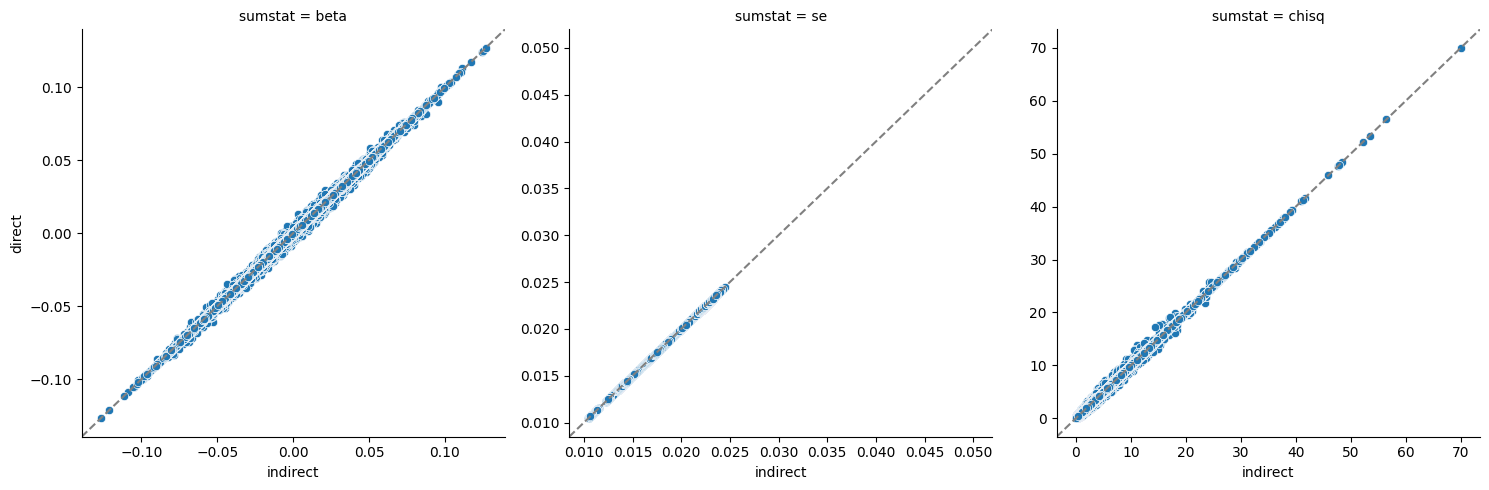

In [37]:
(
    comparison_df
    .pipe(sns.relplot, x="indirect", y="direct", col="sumstat", kind="scatter", facet_kws={"sharex": False, "sharey": False})
    .map(lambda *args, **kwargs: plt.axline((0.05, 0.05), slope=1, color="gray", linestyle="dashed"))
)